In [1]:
global_params = {
    'max_seq_len': 64,
    'gradient_accumulation_steps': 1
}

optim_param = {
    'lr': 3e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

train_params = {
    'batch_size': 10,
    'use_cuda': True,
    'max_len_seq': global_params['max_seq_len'],
    'device': 'cuda' #change this to run on cuda #'cuda:0'
}
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
import sys
sys.path.insert(1, '../')
from utils.packages import *

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict)
    # 3. load the new state dict
    model.load_state_dict(model_dict)
    return model

stats_path = '../data/datasets/synthea/Smaller_cohorts/train_stats/'
condfiles = {'dd':stats_path + 'dd_cond_probs.empirical.p', 
             'dp':stats_path + 'dp_cond_probs.empirical.p',
             'dm':stats_path + 'dm_cond_probs.empirical.p',
             'pp':stats_path + 'pp_cond_probs.empirical.p', 
             'pd':stats_path + 'pd_cond_probs.empirical.p',
             'pm':stats_path + 'pd_cond_probs.empirical.p',
             'mm':stats_path + 'mm_cond_probs.empirical.p', 
             'md':stats_path + 'md_cond_probs.empirical.p',
             'mp':stats_path + 'mp_cond_probs.empirical.p',

            }
#train, val, test = train_test_val_split(dataset, train_ratio=0.6, validation_ratio=0.2, test_ratio=0.2)
path='../data/datasets/synthea/Smaller_cohorts/'
train = pd.read_parquet(path + 'train.parquet')
val = pd.read_parquet(path + 'val.parquet')
test = pd.read_parquet(path + 'test.parquet')

/var/local/home/linler17/.conda/envs/masterenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### MLM

In [170]:
files = {'code':'../data/vocabularies/Synthea/snomedrxnorm.npy',
         'age':'../data/vocabularies/Synthea/age.npy'
        }
tokenizer = EHRTokenizer(task='MLM', filenames=files)
model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

In [4]:
traind = EHRDataset(train, max_len=train_params['max_len_seq'], conditional_files=condfiles, tokenizer=tokenizer)
#vald = EHRDataset(val, max_len=train_params['max_len_seq'], tokenizer=tokenizer, conditional_files=condfiles, run_type='val')
#testd = EHRDataset(test, max_len=train_params['max_len_seq'], tokenizer=tokenizer, conditional_files=condfiles, run_type='test')
#trainloader = trainloader.cpu()

Loading data


In [29]:
trainloader = torch.utils.data.DataLoader(traind, batch_size=1, pin_memory=True)

In [6]:
conf = BertConfig(model_config)
model = BertForMaskedLM(conf)
PATH = "../saved_models/MLM/model_with_prior_82test"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


In [98]:
sequence_output = []
masks = torch.Tensor()
seq = torch.Tensor()

sentences = []
for idx, batch in enumerate(trainloader):
    age, gender, code, position, segment, mask, label, prior_guide = batch
    #sentence = tokenizer.convert_tokens_to_ids(code, 'code')
    loss, preds, labels, attention_scores, sequence_outputs = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
    #age_embedding = embedding_output[2]
    #disease_embed = embedding_output[1]
    #gender_embed = embedding_output[3]
    
    sentence = tokenizer.convert_ids_to_tokens(code.numpy().squeeze(), 'code')
    sentences.extend(sentence)
    seq_out = sequence_outputs[-1]
    
    seq = torch.cat((seq, seq_out), 0)
    if idx == 5:
        break

In [85]:
s = seq.reshape(seq.shape[0] *  seq.shape[1], -1).detach().numpy()

###### Visualize Diseaseseq Embeddings

In [87]:
pca = TSNE(n_components=2)
X_transformed = pca.fit_transform(s)

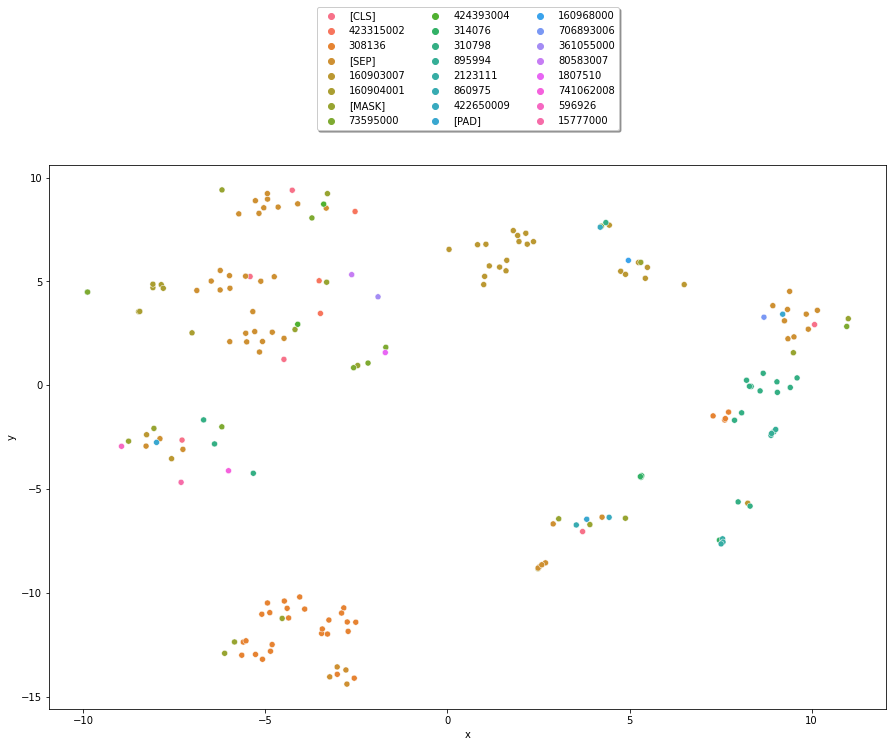

In [113]:
fig, ax = plt.subplots(figsize=(15, 10)) #each subplot of size 6x6, each row will hold 4 plots
df = pd.DataFrame.from_dict({'x':X_transformed[:,0],'y':X_transformed[:,1], 'labels':sentences})
sns.scatterplot(data=df,x='x',y='y', hue='labels',ax=ax)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),ncol=3, fancybox=True, shadow=True)

###### Visualize Attention

##### Readmission

In [3]:
files = {'code':'../data/vocabularies/Synthea/Small_cohorts/diagnosiscodes.npy',
         'age':'../data/vocabularies/Synthea/Small_cohorts/age.npy'
        }

feature_types = {'diagnosis':True, 'medications':False, 'procedures':False}
tokenizer = EHRTokenizer(task='readmission', filenames=files)
folderpath = '../data/pytorch_datasets/Synthea/Small_cohorts/'
testd = EHRDatasetReadmission(test, feature_types=feature_types, max_len=train_params['max_len_seq'], tokenizer=tokenizer, conditional_files=condfiles, save_folder=folderpath, run_type='test_readmission', nvisits=3)

model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }

Loading data


In [27]:
testloader = torch.utils.data.DataLoader(testd, batch_size=32, shuffle=True, num_workers=4)
conf = BertConfig(model_config)
model = BertSinglePrediction(conf, num_labels=1) 
PATH = "../saved_models/MLM/BEHRT_small_cohorts_synthea"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

t_total value of -1 results in schedule not being applied


In [31]:
seq = torch.Tensor()
adm_labels = []

for idx, batch in enumerate(testloader):
    age, gender, code, position, segment, mask, label, prior_guide = batch
    #sentence = tokenizer.convert_tokens_to_ids(code, 'code')
    adm_labels.extend(label[:, 0].tolist())
    loss, preds, labels, attention_scores, poolout = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=label, prior_guide=prior_guide)
    
    seq = torch.cat((seq, poolout), 0)
    
    if idx == 200:
        break

###### Visualize Encoder Layers

<AxesSubplot:xlabel='x', ylabel='y'>

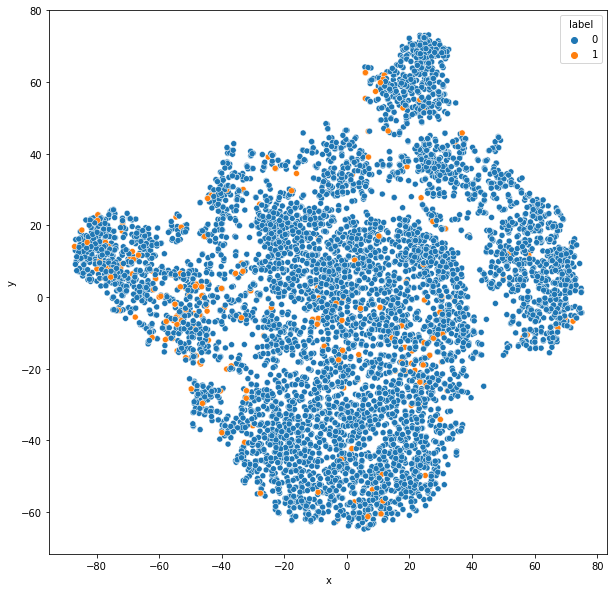

In [32]:
fig, ax = plt.subplots(figsize=(10, 10)) #each subplot of size 6x6, each row will hold 4 plots
tsne = TSNE(n_components=2)

sequence_embed_reduced_embeds = tsne.fit_transform(seq.detach().numpy())
df = pd.DataFrame.from_dict({'x':sequence_embed_reduced_embeds[:,0],'y':sequence_embed_reduced_embeds[:,1], 'label':adm_labels})

sns.scatterplot(data=df,x='x',y='y', hue='label',ax=ax)

###### Visualize Attention

##### Nextvisit

In [171]:
files = {'code':'../data/vocabularies/Synthea/Small_cohorts/diagnosiscodes.npy',
         'age':'../data/vocabularies/Synthea/Small_cohorts/age.npy',
         'labels':'../data/vocabularies/Synthea/Small_cohorts/labeldiagnosiscode.npy'
        }
tokenizer = EHRTokenizer(task='nextvisit', filenames=files)
model_config = {
        'vocab_size': len(tokenizer.getVoc('code').keys()), # number of disease + symbols for word embedding
        'hidden_size': 288, #tune.choice([100, 150, 288]), #288, # word embedding and seg embedding hidden size
        'seg_vocab_size': 2, # number of vocab for seg embedding
        'age_vocab_size': len(tokenizer.getVoc('age').keys()), # number of vocab for age embedding,
        'gender_vocab_size': 3,
        'max_position_embeddings': train_params['max_len_seq'], # maximum number of tokens
        'hidden_dropout_prob': 0.1, # dropout rate
        'num_hidden_layers': 6, #4, # number of multi-head attention layers required
        'num_attention_heads': 12, # number of attention heads
        'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
        'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
        'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
        'initializer_range': 0.02, # parameter weight initializer range
        'use_prior':False,
        'reg':0.1,
        'age':True,
        'gender':False,
        'epochs':20,
    }
conf = BertConfig(model_config)

In [96]:
folderpath = '../data/pytorch_datasets/Synthea/Small_cohorts/'
feature_types = {'diagnosis':True, 'medications':False, 'procedures':False}
testd = EHRDatasetCodePrediction(test, max_len=train_params['max_len_seq'], tokenizer=tokenizer, feature_types=feature_types, save_folder=folderpath, conditional_files=condfiles, run_type='test_nextvisit')
testloader = torch.utils.data.DataLoader(testd, batch_size=10, shuffle=True, num_workers=4)

Loading data


In [97]:
model = BertMultiLabelPrediction(conf, num_labels=len(tokenizer.getVoc('label').keys())) 
PATH = "../saved_models/MLM/BEHRT_small_cohorts_synthea"
model = load_model(PATH, model)
params = list(model.named_parameters())
optim = adam(params, optim_param)

mlb = MultiLabelBinarizer(classes=list(tokenizer.getVoc('label').values()))
mlb.fit([[each] for each in list(tokenizer.getVoc('label').values())])

t_total value of -1 results in schedule not being applied


MultiLabelBinarizer(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                             28, 29, ...])

In [156]:
from sklearn.metrics import multilabel_confusion_matrix

In [166]:
for batch in testloader:
    age, gender, code, position, segment, mask, labels, prior_guide = batch
    #sentence = tokenizer.convert_tokens_to_ids(code, 'code')
    labels = torch.tensor(mlb.transform(labels), dtype=torch.float32)
    loss, preds, labels_out, attention_scores = model(code, age_ids=age, gender_ids=gender, seg_ids=segment, posi_ids=position, attention_mask=mask, labels=labels, prior_guide=prior_guide)
    
    sig = nn.Sigmoid()
    output=sig(preds).detach().cpu().numpy()
    labels_out = labels_out.cpu().numpy()
    #aucpr = average_precision_score(labels, output, average=None)
    #roc = skm.roc_auc_score(labels,preds.detach().numpy(), average='samples')
    break

###### Visualize Attention